# Classification

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

### Define and train model, get calibration probabilities

In [2]:
# Generate synthetic dataset
X, y = datasets.make_classification(n_samples=10000, n_features=20, n_classes=10, n_informative=15, random_state=42)


# Split Train vs Rest (60 / 40)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.6, random_state=42)

# Split Rest into Val vs (Cal + Test) (20 / 20 relative to total, so 0.5 of rest)
X_val, X_rest, y_val, y_rest = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

# Split remaining into Cal vs Test (10 / 10 relative to total, so 0.5 of remaining)
X_cal, X_test, y_cal, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


model = MLPClassifier(hidden_layer_sizes=(50,5), activation='relu', solver='adam', max_iter=5000, random_state=42)
model.fit(X_train, y_train)

val_probs = model.predict_proba(X_val)
cal_probs = model.predict_proba(X_cal)
test_probs = model.predict_proba(X_test)

# Print set sizes
print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")
print(f"Calibration set size: {len(y_cal)}")
print(f"Test set size: {len(y_test)}")

Training set size: 6000
Validation set size: 2000
Calibration set size: 1000
Test set size: 1000


### Thresshold predictive sets (TPS)

In [3]:
def TPS(cal_probs, y_cal, test_probs, y_test, alpha=0.1, disallow_empty=True):

    # Determine quantile level
    n = len(y_cal)
    q_level = np.ceil((n+1)*(1-alpha))/n

    # Calibration scores
    cal_scores = 1-cal_probs[np.arange(n), y_cal]
    q_hat = np.quantile(cal_scores, q_level, method='higher')

    # Compute prediction sets and empirical coverage
    prediction_sets = test_probs >= (1-q_hat)

    # Ensure no empty prediction sets by adding the most probable class
    if disallow_empty:
        empty_sets = np.where(np.sum(prediction_sets, axis=1) == 0)[0]
        for i in empty_sets:
            max_index = np.argmax(test_probs[i])
            prediction_sets[i, max_index] = True

    empirical_coverage = prediction_sets[np.arange(len(test_probs)), y_test].mean()
    singleton_rate = np.mean(np.sum(prediction_sets, axis=1) == 1)
    singleton_hit_rate = np.mean(prediction_sets[np.arange(len(test_probs)), y_test][np.sum(prediction_sets, axis=1) == 1])

    # Define prediction sets
    preds = {}
    for i in range(len(test_probs)):
        preds[i] = [int(j) for j in np.where(test_probs[i] >=  (1-q_hat))[0]]

    return cal_scores, q_hat, preds, empirical_coverage, singleton_rate, singleton_hit_rate

In [4]:
# Determine quantile level
alpha = 0.1
n = len(y_cal)
q_level = np.ceil((n+1)*(1-alpha))/n

# Calibration scores
cal_scores = 1-cal_probs[np.arange(n), y_cal]
q_hat = np.quantile(cal_scores, q_level, method='higher')

# Compute prediction sets and empirical coverage
prediction_sets = test_probs >= (1-q_hat)

# Ensure no empty prediction sets by adding the most probable class
if True:
    empty_sets = np.where(np.sum(prediction_sets, axis=1) == 0)[0]
    for i in empty_sets:
        max_index = np.argmax(test_probs[i])
        prediction_sets[i, max_index] = True


### Adaptive prediction sets

In [5]:
def APS(cal_probs, y_cal, test_probs, y_test, alpha=0.1):
    # Determine quantile level
    n = len(y_cal)
    q_level = np.ceil((n+1)*(1-alpha))/n
    cal_range = np.arange(n)

    # Compute calibration scores
    true_prob = cal_probs[cal_range, y_cal]                                                    # true class probabilities
    cal_pi = cal_probs.argsort(1)[:,::-1]                                                      # Indices that would sort probs descending
    cal_srt = np.take_along_axis(cal_probs, cal_pi, axis=1).cumsum(axis=1)                     # Sorted cumulative sums
    cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[cal_range, y_cal] # Get scores for true class

    # Break ties randomly
    u = np.random.uniform(0, 1, size = n)
    cal_scores = cal_scores - u * true_prob   # Subtract random fraction of true class prob to break ties


    # Get the score quantile
    q_hat = np.quantile(cal_scores, q_level, method='higher')

    # Get prediction sets for test data
    test_pi = test_probs.argsort(1)[:,::-1]                                     # Indices that would sort test probs descending
    test_srt = np.take_along_axis(test_probs, test_pi, axis=1).cumsum(axis=1)   # Sorted cumulative sums

    # Define prediction sets
    n_test = test_probs.shape[0]
    test_range = np.arange(n_test)
    mask = test_srt < q_hat                                                         # classes strictly below qhat
    first_cross = (test_srt >= q_hat).argmax(axis=1)                                # index of first crossing
    mask[np.arange(len(mask)), first_cross] = True                                  # ensure inclusion of crossing class
    prediction_sets = np.take_along_axis(mask, test_pi.argsort(axis=1), axis=1)     # Get prediction sets

    # Calculate empirical coverage
    empirical_coverage = prediction_sets[test_range, y_test].mean()
    singleton_rate = np.mean(np.sum(prediction_sets, axis=1) == 1)
    singleton_hit_rate = np.mean(prediction_sets[test_range, y_test][np.sum(prediction_sets, axis=1) == 1])

    # Define prediction sets
    preds = {}
    for i in test_range:
        preds[i] = [int(j) for j in np.where(prediction_sets[i])[0]]

    return cal_scores, q_hat, preds, empirical_coverage, singleton_rate, singleton_hit_rate


### RAPS

In [6]:
def RAPS(cal_probs, y_cal, test_probs, y_test, alpha=0.1, lam_reg=0.3, k_reg=2, disallow_zero_sets=True, rand=True):
    n_cal = len(y_cal)
    cal_range = np.arange(n_cal)
    q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
    u_cal = np.random.uniform(0, 1, size = n_cal)

    # Regularization vector
    reg_vec = np.array(k_reg*[0,] + (cal_probs.shape[1]-k_reg)*[lam_reg,])[None,:]


    # Compute calibration scores
    cal_pi = cal_probs.argsort(1)[:,::-1]; 
    cal_srt = np.take_along_axis(cal_probs,cal_pi,axis=1)
    cal_srt_reg = cal_srt + reg_vec
    cal_true = np.where(cal_pi == y_cal[:,None])[1]
    cal_scores = cal_srt_reg.cumsum(axis=1)[cal_range, cal_true] - u_cal * cal_srt_reg[cal_range, cal_true]

    # Get the score quantile
    q_hat = np.quantile(cal_scores, q_level, method='higher')
    
    # Get prediction sets for test data
    n_test = test_probs.shape[0]
    test_range = np.arange(n_test)
    u_test = np.random.uniform(0, 1, size = n_test)

    val_pi = test_probs.argsort(1)[:,::-1]
    val_srt = np.take_along_axis(test_probs,val_pi,axis=1)
    val_srt_reg = val_srt + reg_vec
    mask = (val_srt_reg.cumsum(axis=1) - u_test[:,None] * val_srt_reg) <= q_hat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= q_hat
    if disallow_zero_sets:
        mask[:,0] = True
    
    prediction_sets = np.take_along_axis(mask, val_pi.argsort(axis=1), axis=1)

    # Calculate empirical coverage
    empirical_coverage = prediction_sets[test_range, y_test].mean()
    singleton_rate = np.mean(np.sum(prediction_sets, axis=1) == 1)
    singleton_hit_rate = np.mean(prediction_sets[test_range, y_test][np.sum(prediction_sets, axis=1) == 1])
    
    # Define prediction sets
    preds = {}
    for i in test_range:
        preds[i] = [int(j) for j in np.where(prediction_sets[i])[0]]

    return cal_scores, q_hat, preds, empirical_coverage, singleton_rate, singleton_hit_rate


### Final boss: DAPS

In [7]:

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering # Unsupervised clustering
from sklearn.tree import DecisionTreeClassifier # Supervised clustering
from sklearn.neighbors import KNeighborsClassifier # Supervised clustering


# Fit PCA and clustering model on training data
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)


# cluster_model = KMeans(n_clusters=10, random_state=42)
# cluster_model = AgglomerativeClustering(n_clusters=10)
# cluster_model = DecisionTreeClassifier(max_depth=5, random_state=42)
cluster_model = KNeighborsClassifier(n_neighbors=3)



cluster_model.fit(X_train_pca, y_train)
test_clusters = cluster_model.predict(pca.transform(X_test))
cal_clusters = cluster_model.predict(pca.transform(X_cal))
val_clusters = cluster_model.predict(pca.transform(X_val))


def DAPS(cal_probs, y_cal, cal_clusters, test_probs, y_test, test_clusters, alpha=0.1, lam_reg=0.3, k_reg=2, beta = 0.1, disallow_zero_sets=True, rand=True):
    
    # Determine quantile level
    n_cal = len(y_cal)
    cal_range = np.arange(n_cal)
    q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
    u_cal = np.random.uniform(0, 1, size = n_cal)

    # Regularization vector
    reg_vec = np.array(k_reg*[0,] + (cal_probs.shape[1]-k_reg)*[lam_reg,])[None,:]


    # Compute calibration scores
    cal_pi = cal_probs.argsort(1)[:,::-1]; 
    cal_srt = np.take_along_axis(cal_probs,cal_pi,axis=1)
    cal_srt_reg = cal_srt + reg_vec
    cal_true = np.where(cal_pi == y_cal[:,None])[1]
    cal_scores = cal_srt_reg.cumsum(axis=1)[cal_range, cal_true] - u_cal * cal_srt_reg[cal_range, cal_true]

    # Diffuse scores with neighboring cluster scores
    diff_scores = cal_scores.copy()
    cluster_means = {}

    for cluster in np.unique(cal_clusters):
        cluster_means[cluster] = np.mean(cal_scores[cal_clusters == cluster], axis=0)              # compute cluster mean score
        indices = np.where(cal_clusters == cluster)[0]                                              # get indices of points in cluster
        diff_scores[indices] = (1 - beta) * cal_scores[indices] + beta * cluster_means[cluster]    # diffuse scores


    # Get the score quantile
    q_hat = np.quantile(diff_scores, q_level, method='higher')
    
        
    # Get base prediction scores for test data
    n_test = test_probs.shape[0]
    test_range = np.arange(n_test)
    u_test = np.random.uniform(0, 1, size = n_test)

    test_pi = test_probs.argsort(1)[:,::-1]
    test_srt = np.take_along_axis(test_probs, test_pi, axis=1)
    test_scores_base = test_srt + reg_vec

    # Diffuse test scores based on cluster assignments
    test_scores = test_scores_base.copy()

    for cluster in np.unique(test_clusters):
        indices = np.where(test_clusters == cluster)[0]
        test_scores[indices] = (1 - beta) * test_scores_base[indices] + beta * cluster_means[cluster]


    # Define prediction sets
    mask = (test_scores.cumsum(axis=1) - u_test[:, None] * test_scores) <= q_hat if rand else test_scores.cumsum(axis=1) - test_scores <= q_hat
    if disallow_zero_sets: 
        mask[:, 0] = True

    prediction_sets = np.take_along_axis(mask, test_pi.argsort(axis=1), axis=1)

    # Calculate empirical coverage
    empirical_coverage = prediction_sets[test_range, y_test].mean()
    singleton_rate = np.mean(np.sum(prediction_sets, axis=1) == 1) 
    singleton_hit_rate = np.mean(prediction_sets[test_range, y_test][np.sum(prediction_sets, axis=1) == 1])
        

    preds = {}
    for i in range(n_test):
        preds[i] = [int(j) for j in np.where(prediction_sets[i])[0]]

    return cal_scores, q_hat, preds, empirical_coverage, singleton_rate, singleton_hit_rate


In [8]:
# For each method, fill out CP dictionary
CP = {"TPS": {}, "APS": {}, "RAPS": {}, "DAPS": {}}
CP["TPS"]["cal_scores"], CP["TPS"]["q_hat"], CP["TPS"]["preds"], CP["TPS"]["empirical_coverage"], CP["TPS"]["singleton_rate"], CP["TPS"]["singleton_hit_rate"] = TPS(cal_probs, y_cal, val_probs, y_val, alpha=0.1)
CP["APS"]["cal_scores"], CP["APS"]["q_hat"], CP["APS"]["preds"], CP["APS"]["empirical_coverage"], CP["APS"]["singleton_rate"], CP["APS"]["singleton_hit_rate"] = APS(cal_probs, y_cal, val_probs, y_val, alpha=0.1)
CP["RAPS"]["cal_scores"], CP["RAPS"]["q_hat"], CP["RAPS"]["preds"], CP["RAPS"]["empirical_coverage"], CP["RAPS"]["singleton_rate"], CP["RAPS"]["singleton_hit_rate"] = RAPS(cal_probs, y_cal, val_probs, y_val, alpha=0.1, lam_reg=0.3, k_reg=2, disallow_zero_sets=True, rand=True)
CP["DAPS"]["cal_scores"], CP["DAPS"]["q_hat"], CP["DAPS"]["preds"], CP["DAPS"]["empirical_coverage"], CP["DAPS"]["singleton_rate"], CP["DAPS"]["singleton_hit_rate"] = DAPS(cal_probs, y_cal, cal_clusters, val_probs, y_val, val_clusters, alpha=0.1, lam_reg=0.3, k_reg=2, beta = 0.1, disallow_zero_sets=True, rand=True)

c:\Users\jacob\miniconda3\envs\deepLearning\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jacob\miniconda3\envs\deepLearning\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
for method in CP.keys():
    print(f"{method} empirical coverage: {np.round(CP[method]['empirical_coverage'], 3)}")

TPS empirical coverage: 0.898
APS empirical coverage: 0.921
RAPS empirical coverage: 0.89
DAPS empirical coverage: 0.877


In [10]:
# Average size of prediction sets
for method in CP.keys():
    sizes = [len(s) for s in CP[method]['preds'].values()]
    avg_size = np.mean(sizes)
    print(f"{method} average prediction set size: {np.round(avg_size, 3)}")

TPS average prediction set size: 2.955
APS average prediction set size: 3.503
RAPS average prediction set size: 3.158
DAPS average prediction set size: 2.951


In [11]:
# Singleton rates and hit ratios
for method in CP.keys():
    singleton_rate = CP[method]['singleton_rate']
    singleton_hit_ratio = CP[method]['singleton_hit_rate']
    print(f"{method} singleton rate: {np.round(singleton_rate, 3)}, singleton hit ratio: {np.round(singleton_hit_ratio, 3)}")

TPS singleton rate: 0.175, singleton hit ratio: 0.877
APS singleton rate: 0.129, singleton hit ratio: 0.922
RAPS singleton rate: 0.0, singleton hit ratio: nan
DAPS singleton rate: 0.0, singleton hit ratio: nan


In [12]:
for i in range(4):
    print(f"Test example {i}, true label: {y_test[i]}")
    print(f"  TPS prediction set:  {CP['TPS']['preds'][i]}")
    print(f"  APS prediction set:  {CP['APS']['preds'][i]}")
    print(f"  RAPS prediction set: {CP['RAPS']['preds'][i]}")
    print(f"  DAPS prediction set: {CP['DAPS']['preds'][i]}")
    print()

Test example 0, true label: 0
  TPS prediction set:  [6]
  APS prediction set:  [6, 7]
  RAPS prediction set: [2, 6, 7]
  DAPS prediction set: [6, 7]

Test example 1, true label: 7
  TPS prediction set:  [0, 1, 6, 7, 8]
  APS prediction set:  [0, 1, 4, 6, 7, 8, 9]
  RAPS prediction set: [1, 6, 7, 8]
  DAPS prediction set: [1, 6, 8]

Test example 2, true label: 6
  TPS prediction set:  [8, 9]
  APS prediction set:  [8, 9]
  RAPS prediction set: [4, 8, 9]
  DAPS prediction set: [4, 8, 9]

Test example 3, true label: 4
  TPS prediction set:  [2, 4, 9]
  APS prediction set:  [2, 4, 6, 9]
  RAPS prediction set: [2, 4, 9]
  DAPS prediction set: [2, 4, 9]



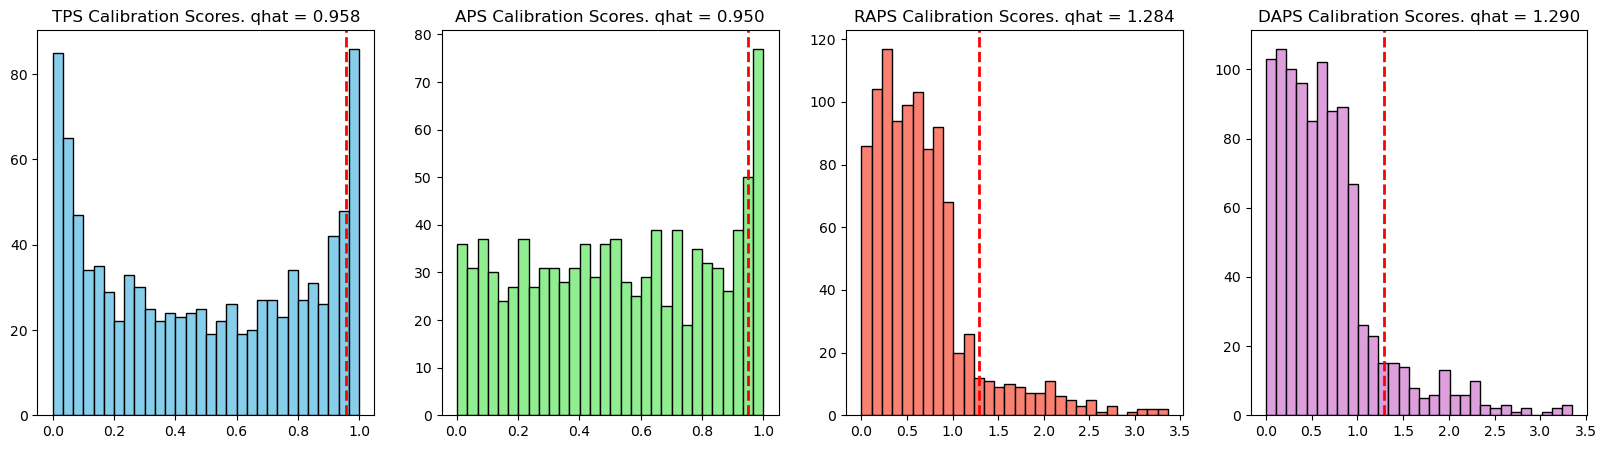

In [13]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

ax[0].hist(CP["TPS"]['cal_scores'], bins=30, color='skyblue', edgecolor='black')
ax[0].axvline(CP["TPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[0].set_title('TPS Calibration Scores. qhat = {:.3f}'.format(CP["TPS"]['q_hat']))

ax[1].hist(CP["APS"]['cal_scores'], bins=30, color='lightgreen', edgecolor='black')
ax[1].axvline(CP["APS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[1].set_title('APS Calibration Scores. qhat = {:.3f}'.format(CP["APS"]['q_hat']))

ax[2].hist(CP["RAPS"]['cal_scores'], bins=30, color='salmon', edgecolor='black')
ax[2].axvline(CP["RAPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[2].set_title('RAPS Calibration Scores. qhat = {:.3f}'.format(CP["RAPS"]['q_hat']))

ax[3].hist(CP["DAPS"]['cal_scores'], bins=30, color='plum', edgecolor='black')
ax[3].axvline(CP["DAPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[3].set_title('DAPS Calibration Scores. qhat = {:.3f}'.format(CP["DAPS"]['q_hat']))

plt.show()

In [14]:
import numpy as np
import cp

labels = np.arange(10)

tps = cp.TPS_conformal(cal_probs=cal_probs,
                       y_cal=y_cal,
                       test_probs=val_probs,
                       y_test=y_val,
                       labels=labels)

aps = cp.APS_conformal(cal_probs=cal_probs,
                       y_cal=y_cal,
                       test_probs=val_probs,
                       y_test=y_val,
                       labels=labels)

raps = cp.RAPS_conformal(cal_probs=cal_probs,
                         y_cal=y_cal,
                         test_probs=val_probs,
                         y_test=y_val,
                         labels=labels)

daps = cp.DAPS_conformal(cal_probs=cal_probs,
                         y_cal=y_cal,
                         cal_clusters=cal_clusters,
                         test_probs=val_probs,
                         y_test=y_val,
                         test_clusters=val_clusters,
                         labels=labels)

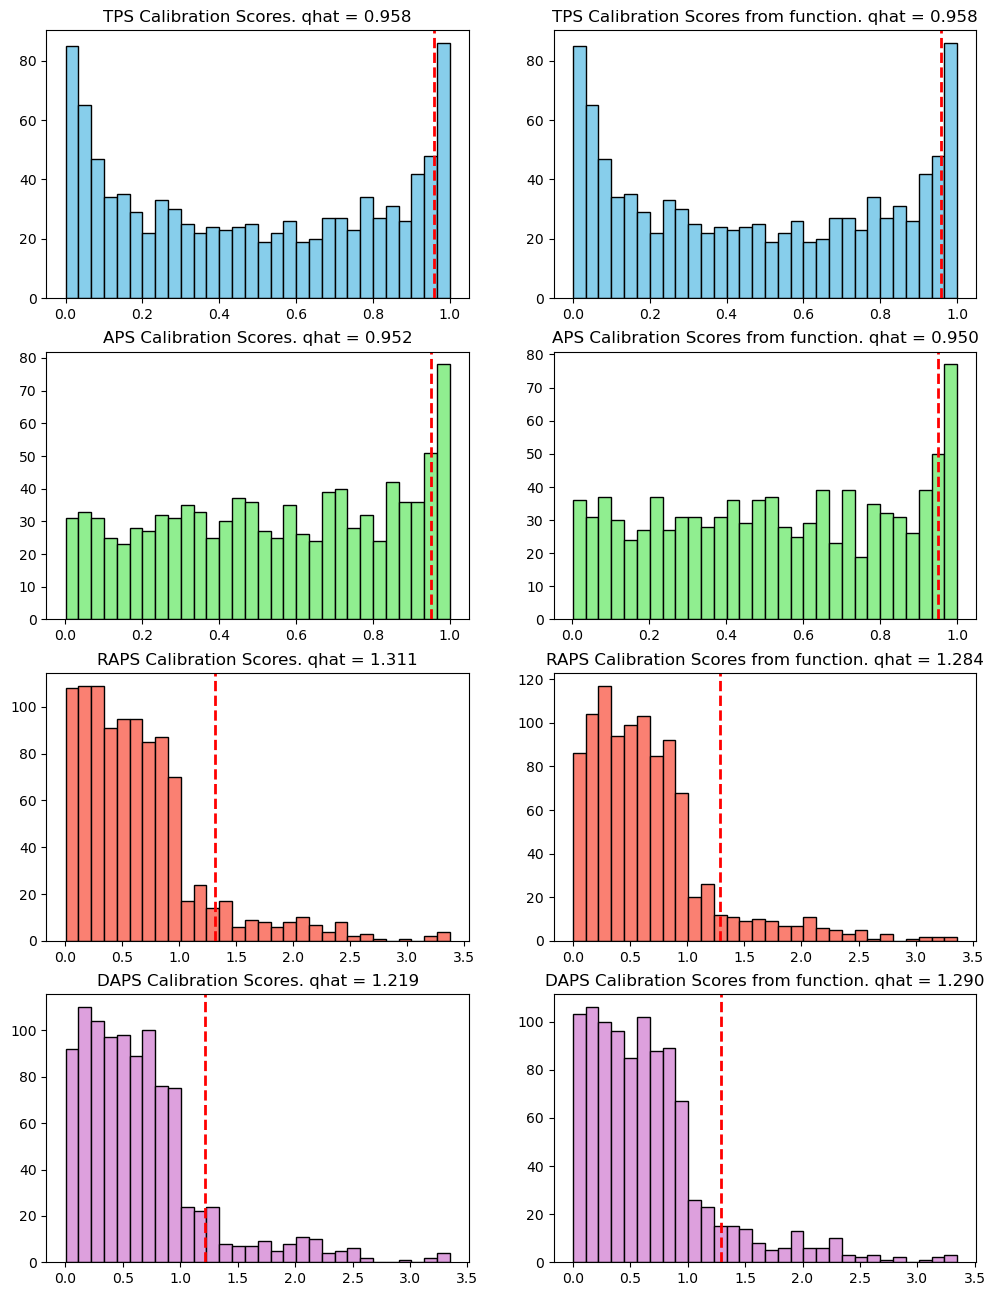

In [15]:
# Compare cal scores from function implementations vs class implementations

fig, ax = plt.subplots(4, 2, figsize=(12,16))

methods = ['TPS', 'APS', 'RAPS', 'DAPS']

ax[0,0].hist(tps.cal_scores, bins=30, color='skyblue', edgecolor='black')
ax[0,0].axvline(tps.q_hat, color='red', linestyle='dashed', linewidth=2)
ax[0,0].set_title('TPS Calibration Scores. qhat = {:.3f}'.format(tps.q_hat))
ax[0,1].hist(CP["TPS"]['cal_scores'], bins=30, color='skyblue', edgecolor='black')
ax[0,1].axvline(CP["TPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[0,1].set_title('TPS Calibration Scores from function. qhat = {:.3f}'.format(CP["TPS"]['q_hat']))

ax[1,0].hist(aps.cal_scores, bins=30, color='lightgreen', edgecolor='black')
ax[1,0].axvline(aps.q_hat, color='red', linestyle='dashed', linewidth=2)
ax[1,0].set_title('APS Calibration Scores. qhat = {:.3f}'.format(aps.q_hat))
ax[1,1].hist(CP["APS"]['cal_scores'], bins=30, color='lightgreen', edgecolor='black')
ax[1,1].axvline(CP["APS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[1,1].set_title('APS Calibration Scores from function. qhat = {:.3f}'.format(CP["APS"]['q_hat']))

ax[2,0].hist(raps.cal_scores, bins=30, color='salmon', edgecolor='black')
ax[2,0].axvline(raps.q_hat, color='red', linestyle='dashed', linewidth=2)
ax[2,0].set_title('RAPS Calibration Scores. qhat = {:.3f}'.format(raps.q_hat))
ax[2,1].hist(CP["RAPS"]['cal_scores'], bins=30, color='salmon', edgecolor='black')
ax[2,1].axvline(CP["RAPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[2,1].set_title('RAPS Calibration Scores from function. qhat = {:.3f}'.format(CP["RAPS"]['q_hat']))

ax[3,0].hist(daps.cal_scores, bins=30, color='plum', edgecolor='black')
ax[3,0].axvline(daps.q_hat, color='red', linestyle='dashed', linewidth=2)
ax[3,0].set_title('DAPS Calibration Scores. qhat = {:.3f}'.format(daps.q_hat))
ax[3,1].hist(CP["DAPS"]['cal_scores'], bins=30, color='plum', edgecolor='black')
ax[3,1].axvline(CP["DAPS"]['q_hat'], color='red', linestyle='dashed', linewidth=2)
ax[3,1].set_title('DAPS Calibration Scores from function. qhat = {:.3f}'.format(CP["DAPS"]['q_hat']))   

plt.show()

In [98]:
import cp as cp
import CP_gemini as cpg

labels = ["cat0", "cat1", "cat2", "cat3", "cat4", "cat5", "cat6", "cat7", "cat8", "cat9"]

daps = cpg.DAPS(alpha=0.1, k_reg=2, lam_reg=0.3, beta=0.1, allow_zero_sets=False)
daps.fit(cal_probs, y_cal, cal_clusters)
daps_sets = daps.predict(test_probs, test_clusters)
daps_metrics = cpg.ConformalMetrics(daps_sets, y_test).get_metrics()
daps_preds = daps.convert_to_sets(daps_sets, labels=labels)
daps_metrics["Coverage"]

np.float64(0.854)

In [80]:
CP["DAPS"]["empirical_coverage"]

np.float64(0.877)